# Causal Inference in Marketing

One of the primary objectives in marketing is to measure the effectiveness of a marketing campaign, understanding not just the correlation between marketing efforts and outcomes but uncovering the true causal impact of marketing actions on consumer behavior. Having precise measurements of the marketing campaign can allow a business to determine its profitability and allows the business to make informed decisions for future marketing efforts.

The method that we will use to uncover this is called **Uplift Modeling** which applies an econometric technique called causal inference to get these measurements. **Causal Inference** in turn allows us to use any machine learning algorithm to estimate the **Individual Treatment Effects**, which are the measures of how an individual responded from a marketing campaign on business objectives such as visits or sales.

I will begin the exposition into this by importing packages and data. I explore two popular packages for causal inference, CausalML and EconML.

- [CausalML](https://github.com/uber/causalml): is developed by a team at Uber and provides a suite of uplift modeling and causal inference methods
- [EconML](https://github.com/py-why/EconML): is developed by a team at Microsoft and also provides a suit of causal inference methods

I will import the T-learner from CasualML and the DML learner from EconML. In addition, I will include a function from CausalML to calculate the AUUC score, a measure of uplift.

In [167]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt

# Import CasualML
from causalml.inference.meta import BaseTClassifier
from causalml.metrics.visualize import auuc_score

# Import EconML
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

## Read in and Prep Data

The uplift data I consider are 4,893,369 sampled observations from [Diemert, Betlei, Renaudin, Amini, Gregoir, Rahier](https://arxiv.org/pdf/2111.10106)'s paper, "A Large Scale Benchmark for Individual
Treatment Effect Prediction and Uplift Modeling."

In [168]:
df = pd.read_csv("data/uplift_data.csv", index_col=False)
n = df.shape[0]
print(f"There are {n} observations in this data")
df.head(3)

There are 4893369 observations in this data


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.214383,4.679882,10.280525,0.346360,0.294443,10.655268,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,8.214383,4.679882,10.280525,0.709409,0.294443,11.718895,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.214383,4.679882,10.280525,1.128518,0.294443,9.703094,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [3]:
control_visit_rate = df.query("treatment == 0")['visit'].mean()
control_conversion_rate = df.query("treatment == 0 and visit == 1")['conversion'].mean()
print(f"The control group had an {round(control_visit_rate, 2)*100}% visit rate, of these visits there was a {round(control_conversion_rate, 2)*100}% conversion rate")

treatment_visit_rate = df.query("treatment == 1")['visit'].mean()
treatment_conversion_rate = df.query("treatment == 1 and visit == 1")['conversion'].mean()
print(f"The treatment group had a {round(treatment_visit_rate, 2)*100}% visit rate, of these visits there was a {round(treatment_conversion_rate, 2)*100}% conversion rate")

The control group had an 4.0% visit rate, of these visits there was a 5.0% conversion rate
The treatment group had a 5.0% visit rate, of these visits there was a 6.0% conversion rate


In [7]:
# Features, treatment, and outcome
features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
X = df[features]
T = df['treatment']
y = df['visit']

In [8]:
# Split the data into train and test
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.3, random_state=42)

## Fit a T-Learning Model

In [ ]:
# next todo: equations for these + why 

In [111]:
# Let's use the t-learner as the causal inference model with XGBoost as the underlying estimator
model_t = BaseTClassifier(learner=XGBClassifier(max_depth=3, learning_rate = 0.2, reg_lambda = 0.2, random_state=42))

In [112]:
# Fit the model and collect the values into a list
model_t.fit(X_train, T_train, y_train)
ite_t = model_t.predict(X_test)
ite_t = [value[0] for value in ite_t]

## Fit a Double Machine Learning Model

In [51]:
model_dml = DML(
    model_y=XGBRegressor(),
    model_t=XGBClassifier(),
    model_final=StatsModelsLinearRegression(fit_intercept=False),
    discrete_treatment=True
)
model_dml.fit(y_train, T_train, X=X_train)

In [53]:
ite_dml = model_dml.effect(X_test)
ite_dml

array([ 0.00252268,  0.00301293, -0.00319097, ..., -0.00243622,
       -0.00405872,  0.00300992])

In [113]:
# collect into one dataframe
df_test = pd.DataFrame({"treatment": T_test, "outcome": y_test, "ite_t": ite_t, "ite_dml": ite_dml})
df_test.head()

,treatment,outcome,ite_t,ite_dml
2581038,1,0,0.000249,0.002523
2409955,0,0,0.000060,0.003013
4370615,1,0,0.000148,-0.003191
4479919,0,0,0.000251,-0.001672
1950040,1,0,0.000201,-0.003157


In [121]:
# We want to look at outcomes for the treatment and control groups, which we will do a cumulative sum over shortly
C = df_test.query('treatment == 0').shape[0]  
T = df_test.query('treatment != 0').shape[0] 

# Control and treatment labels
df_test["control_outcomes"] = np.where(
    df_test["treatment"] == 0,
    df_test["outcome"],
    0,
)
df_test["treatment_outcomes"] = np.where(
    df_test["treatment"] != 0,
    df_test["outcome"],
    0,
)

## Uplift curve
Let's make the uplift curve, note while this looks similar to the AUC curve, it is different. The x-axis in this case represents the population selected for treatment. So at the origin when x = 0, this is when we do not give treatment to anybody; in contrast when x = 1, this is when we give treatment to everybody. The y-axis measures the uplift between the difference of predicted treatment and control outcomes. A standard thing to do, is to also sort the individuals so that the highest uplift individuals have their uplift recorded first (by sorting them from highest uplift to lowest) which will give the curve the concave shape when it out performs the baseline random treatment assignment model

In [123]:
# Sort the test data by uplift score in descending order
df_test_sorted_t = df_test.sort_values(by='ite_t', ascending=False)
df_test_sorted_t.head(6)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes
29407,1,1,0.573921,0.123358,0,1
2060822,0,1,0.569687,0.138847,1,0
836869,1,1,0.534270,0.163441,0,1
635138,1,0,0.513666,0.156466,0,0
3728256,0,0,0.509924,0.191087,0,0
1240508,1,0,0.509740,0.136565,0,0


In [124]:
# Cumulative sums normalized
df_test_sorted_t["control_sum_t"] = df_test_sorted_t["control_outcomes"].cumsum() / C
df_test_sorted_t["treatment_sum_t"] = df_test_sorted_t["treatment_outcomes"].cumsum() / T
df_test_sorted_t["uplift_t"] = df_test_sorted_t["treatment_sum_t"] - df_test_sorted_t["control_sum_t"]

# Display the DataFrame
df_test_sorted_t.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t
1057728,1,0,-0.250377,0.010779,0,0,0.038036,0.048493,0.010457
2573124,1,0,-0.253988,0.089339,0,0,0.038036,0.048493,0.010457
2024869,0,0,-0.256361,0.003993,0,0,0.038036,0.048493,0.010457


In [125]:
# We want to make bins of the percentage rank for plotting
df_test_sorted_t['rank'] = df_test_sorted_t['ite_t'].rank(ascending=False, method='min')
df_test_sorted_t['percent_rank'] = df_test_sorted_t['rank'].rank(pct=True)
df_test_sorted_t.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t,rank,percent_rank
1057728,1,0,-0.250377,0.010779,0,0,0.038036,0.048493,0.010457,1468009.0,0.999999
2573124,1,0,-0.253988,0.089339,0,0,0.038036,0.048493,0.010457,1468010.0,0.999999
2024869,0,0,-0.256361,0.003993,0,0,0.038036,0.048493,0.010457,1468011.0,1.000000


In [131]:
# Do the same ordering and rankings to get the uplift for the DML model
df_test_sorted_dml = df_test.sort_values(by='ite_dml', ascending=False)
df_test_sorted_dml.head(6)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes
4729915,1,1,0.427447,0.247288,0,1
2050264,0,1,0.268898,0.225487,1,0
4502913,1,0,0.282517,0.224321,0,0
29759,1,1,0.381779,0.221400,0,1
2919528,1,1,0.314697,0.220610,0,1
838442,1,0,0.395737,0.212802,0,0


In [132]:
# Cumulative sums normalized
df_test_sorted_dml["control_sum_dml"] = df_test_sorted_dml["control_outcomes"].cumsum() / C
df_test_sorted_dml["treatment_sum_dml"] = df_test_sorted_dml["treatment_outcomes"].cumsum() / T
df_test_sorted_dml["uplift_dml"] = df_test_sorted_dml["treatment_sum_dml"] - df_test_sorted_dml["control_sum_dml"]

# Display the DataFrame
df_test_sorted_dml.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_dml,treatment_sum_dml,uplift_dml
1022716,1,0,0.060639,-0.016046,0,0,0.038032,0.048493,0.010461
1823760,0,1,-0.021979,-0.016710,1,0,0.038036,0.048493,0.010457
4460604,1,0,0.021298,-0.017142,0,0,0.038036,0.048493,0.010457


In [133]:
# We want to make bins of the percentage rank for plotting
df_test_sorted_dml['rank'] = df_test_sorted_dml['ite_dml'].rank(ascending=False, method='min')
df_test_sorted_dml['percent_rank'] = df_test_sorted_dml['rank'].rank(pct=True)
df_test_sorted_dml.tail(3)

,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_dml,treatment_sum_dml,uplift_dml,rank,percent_rank
1022716,1,0,0.060639,-0.016046,0,0,0.038032,0.048493,0.010461,1468009.0,0.999999
1823760,0,1,-0.021979,-0.016710,1,0,0.038036,0.048493,0.010457,1468010.0,0.999999
4460604,1,0,0.021298,-0.017142,0,0,0.038036,0.048493,0.010457,1468011.0,1.000000


In [154]:
# concat them together to keep the same x-axis ordering to include in both plots
df_test_sorted = pd.concat([df_test_sorted_t.reset_index(), df_test_sorted_dml.reset_index()[["uplift_dml"]]], axis=1)
df_test_sorted.tail(3)

,index,treatment,outcome,ite_t,ite_dml,control_outcomes,treatment_outcomes,control_sum_t,treatment_sum_t,uplift_t,rank,percent_rank,uplift_dml
1468008,1057728,1,0,-0.250377,0.010779,0,0,0.038036,0.048493,0.010457,1468009.0,0.999999,0.010461
1468009,2573124,1,0,-0.253988,0.089339,0,0,0.038036,0.048493,0.010457,1468010.0,0.999999,0.010457
1468010,2024869,0,0,-0.256361,0.003993,0,0,0.038036,0.048493,0.010457,1468011.0,1.000000,0.010457


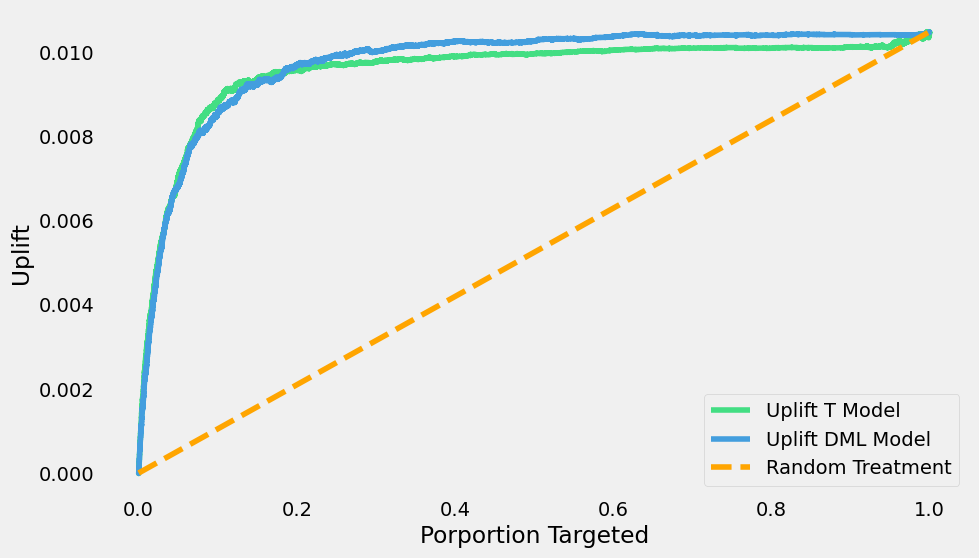

In [153]:
x_axis = df_test_sorted.percent_rank
gain_t = df_test_sorted.uplift_t
gain_dml = df_test_sorted.uplift_dml
# Plot the data

fig = plt.figure(figsize=(10, 6))
#mpl.rcParams["font.size"] = 8

ax = plt.plot(x_axis, gain_t, color="#43de83", label="Uplift T Model")

plt.plot(x_axis, gain_dml, color="#439ede", label="Uplift DML Model")

plt.plot(
    [0, x_axis.max()],
    [0, gain_t.max()],
    "--",
    color="orange",
    label="Random Treatment",
)

#plt.plot(gain_x, gain_dml, color="darkblue", label="Uplift DML Model")

plt.legend()
plt.xlabel("Porportion Targeted")
plt.ylabel("Uplift")
plt.grid()

In [164]:
auuc_df = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
pd.DataFrame({"Uplift Model": ["T", "DML"], "AUUC": [auuc_df["ite_t"], auuc_df["ite_dml"]]})

,Uplift Model,AUUC
0,T,0.835145
1,DML,0.837537


In [229]:
results = pd.DataFrame({'max_depth': [], 'learning_rate': [], 'reg_lambda': [], 'auuc': []})
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for reg_lambda in reg_lambda_values:
            t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
            t_learner.fit(X_train, T_train, y_train)
            ite_test = t_learner.predict(X_test)
            ite_test = [value[0] for value in ite_test]
            df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
            df_test_sorted = df_test.sort_values(by='ite', ascending=False)
            this_score = auuc_score(df_test_sorted, outcome_col='outcome', treatment_col='treatment')
            this_result = pd.DataFrame({
                'max_depth': [max_depth], 
                'learning_rate': [learning_rate], 
                'reg_lambda': [reg_lambda],
                'auuc': [this_score['ite']]
            })
            results = pd.concat([results, this_result], axis=0)

results.sort_values(by='auuc', ascending=False)
display(results.head(3))

,max_depth,learning_rate,reg_lambda,auuc
0,3.0,0.1,0.0,0.636175
0,3.0,0.1,1.0,0.634141
0,3.0,0.1,2.0,0.638739


## Run again with best parameter setting

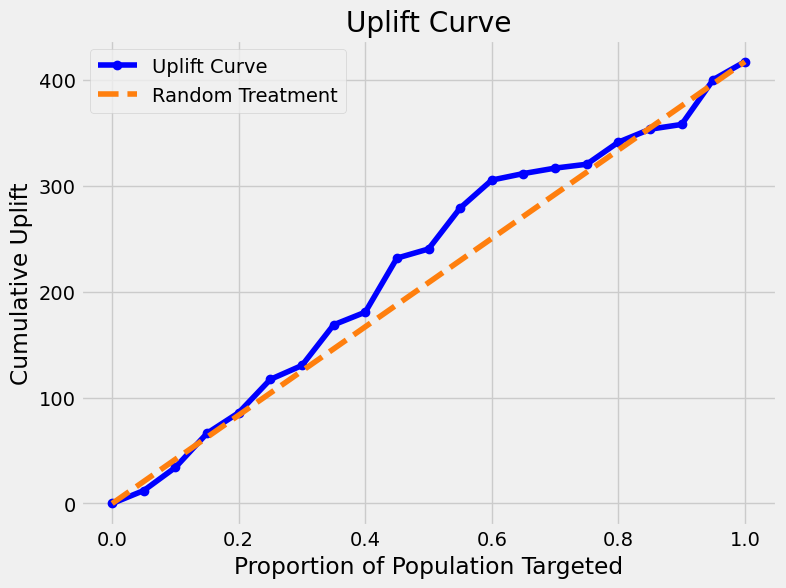

In [230]:
max_depth = 3
learning_rate = 0.1
reg_lambda = 0

t_learner = BaseTClassifier(learner=XGBClassifier(max_depth=max_depth, learning_rate = learning_rate, reg_lambda = reg_lambda, random_state=42))
t_learner.fit(X_train, T_train, y_train)
ite_test = t_learner.predict(X_test)
ite_test = [value[0] for value in ite_test]
df_test = pd.DataFrame({"treatment": T_test, "ite": ite_test, "outcome": y_test})
df_test_sorted = df_test.sort_values(by='ite', ascending=False)

# Calculate the cumulative uplift curve
num_bins = 20  # Number of quantiles to divide the data into
df_test_sorted['bin'] = pd.qcut(df_test_sorted.index, q=num_bins, labels=False)

# Initialize cumulative metrics for uplift curve calculation
cumulative_treatment_effect = [0]
cumulative_population = [0]
cumulative_uplift = 0

for bin_num in range(num_bins):
    # Subset data for the current bin
    bin_data = df_test_sorted[df_test_sorted['bin'] == bin_num]
    
    treatment_outcome = bin_data.query('treatment == 1')['outcome'].mean()
    control_outcome = bin_data.query('treatment == 0')['outcome'].mean()
    
    # Calculate bin uplift and cumulative uplift
    bin_uplift = (treatment_outcome - control_outcome) * len(bin_data)
    cumulative_uplift += bin_uplift
    
    # Store cumulative values for plotting
    cumulative_treatment_effect.append(cumulative_uplift)
    cumulative_population.append((bin_num + 1) / num_bins)

# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    cumulative_population, 
    cumulative_treatment_effect, 
    marker='o', 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(cumulative_population)],
    [0, max(cumulative_treatment_effect)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [294]:
# following Microsoft's way
treated = df_test_sorted.query('treatment == 1')
control = df_test_sorted.query('treatment == 0')
df_test_sorted['treatment_cumsum'] = treated['outcome'].cumsum() / len(treated)
df_test_sorted['control_cumsum'] = control['outcome'].cumsum() / len(control)
df_test_sorted = df_test_sorted.ffill().fillna(0) # fill in NA values for treatment and control for observations of the opposite sign

In [295]:
df_test_sorted['percent_rank'] = df_test_sorted['ite'].rank(pct=True, ascending=False)
df_test_sorted['uplift'] = df_test_sorted['treatment_cumsum'] - df_test_sorted['control_cumsum']
df_test_sorted.tail(20)

,treatment,ite,outcome,treatment_cumsum,control_cumsum,percent_rank,uplift
12408,1,-0.093968,1,0.152894,0.104818,0.997775,0.048077
25902,1,-0.094278,0,0.152894,0.104818,0.997951,0.048077
8296,1,-0.094278,1,0.153128,0.104818,0.997951,0.048310
12979,1,-0.094384,0,0.153128,0.104818,0.998126,0.048310
63442,1,-0.098651,0,0.153128,0.104818,0.998243,0.048310
13802,0,-0.101813,0,0.153128,0.104818,0.998360,0.048310
4751,1,-0.107938,0,0.153128,0.104818,0.998478,0.048310
54928,1,-0.108624,1,0.153361,0.104818,0.998595,0.048543
57604,1,-0.110840,0,0.153361,0.104818,0.998712,0.048543
38612,0,-0.118890,0,0.153361,0.104818,0.998829,0.048543


In [296]:
x_axis = [val for val in df_test_sorted['percent_rank'].values]
y_axis = [val for val in df_test_sorted['uplift'].values]

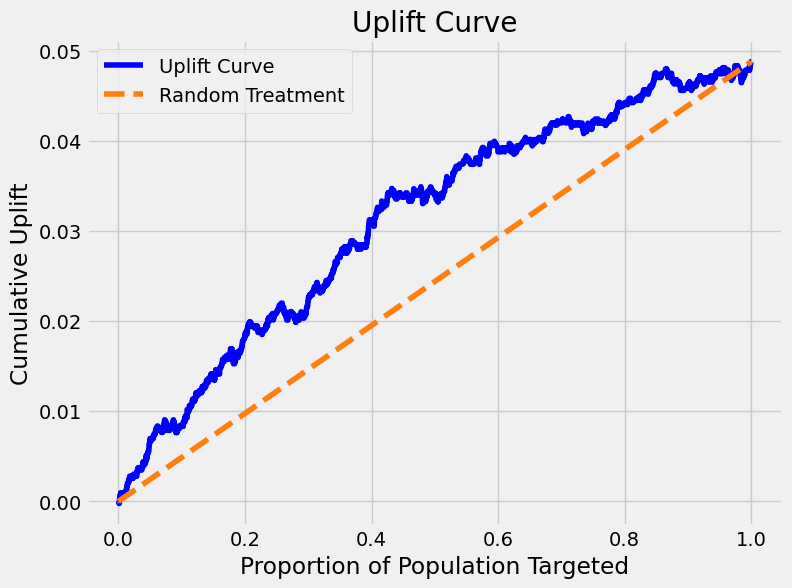

In [297]:
# Plot the uplift curve
plt.figure(figsize=(8, 6))
plt.plot(
    x_axis, 
    y_axis, 
    color='b', 
    label='Uplift Curve'
)
plt.plot(
    [0, max(x_axis)],
    [0, max(y_axis)],
    "--",
    color="tab:orange",
    label="Random Treatment",
)
plt.xlabel('Proportion of Population Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

We will want to target around the first 20% or 45% of the population, as these have the largest distance from the random treatment curve resulting in highest yielding gain